# NSGA2 Generator
This notebook demonstrates the use of the generator `NSGA2Generator` which implements the NSGA-II algorithm from [1]. We show how to set up the optimizer object, use it to solve a test problem, and show off some of the generator's output features. Running this notebook will generate files in a temporary directory on your computer. These files will be cleaned up at the end.

In [1]:
from xopt.generators.ga.nsga2 import NSGA2Generator, PolynomialMutation, SimulatedBinaryCrossover
from xopt.generators.ga.cnsga import CNSGAGenerator
from xopt.resources.test_functions.zdt import construct_zdt
from xopt import Xopt, Evaluator
import logging
import tempfile
import matplotlib.pyplot as plt
import shutil
import os
import pandas as pd
import json

In [2]:
# The NSGA2Generator object emits logger messages
# Configure the logging module to output them to console
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',  # Format for log messages
    datefmt='%Y-%m-%d %H:%M:%S'  # Date/time format
)

In [3]:
# Get the problem ZDT2 and create an Xopt evaluator
prob_vocs, prob_fun, _ = construct_zdt(30, 3)
ev = Evaluator(function=prob_fun)

### Generator Setup and Use
First we create the `NSGA2Generator` object, demonstrate some of its settings, and then use it to solve the ZDT3 test problem.

In [ ]:
# Create the NSGA2 generator with default settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
)

# Let's demonstrate controlling the generator's hyperparameters and settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
    population_size=50,  # How many individuals in a population
    mutation_operator=PolynomialMutation(pm=1/30, eta_m=20),  # Can manually specify mutation operator and hyperparameters
    crossover_operator=SimulatedBinaryCrossover(delta_1=0.5, delta_2=0.5, eta_c=20),  # Similarly can specify crossover manually
    deduplicate_output=True,  # Performs deduplication of candidate individuals. Ensure unique outputs from generator.
)

2025-03-02 18:11:50 - xopt.generator - INFO - Initialized generator nsga2
2025-03-02 18:11:50 - xopt.generator - INFO - Initialized generator nsga2


In [5]:
# Run the optimizer for a few generations. Notice log output printed below this cell
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)

for _ in range(3):
    X.step()

2025-03-02 18:11:50 - xopt.base - INFO - Running Xopt step
2025-03-02 18:11:50 - xopt.generators.ga.nsga2 - INFO - generated 50 candidates in 2.65ms (removed 0 duplicate individuals)
2025-03-02 18:11:50 - xopt.generators.ga.nsga2 - INFO - adding 50 new evaluated individuals to generator
2025-03-02 18:11:50 - xopt.generators.ga.nsga2 - INFO - completed generation 1 in 0.020s (n_feasible=0, n_err=0, children_performance=0.000s (0.000s), add_data_round=0, fevals=50, n_candidates=50)
2025-03-02 18:11:50 - xopt.base - INFO - Running Xopt step
2025-03-02 18:11:50 - xopt.generators.ga.nsga2 - INFO - generated 50 candidates in 99.05ms (removed 0 duplicate individuals)
2025-03-02 18:11:50 - xopt.generators.ga.nsga2 - INFO - adding 50 new evaluated individuals to generator
2025-03-02 18:11:50 - xopt.generators.ga.nsga2 - INFO - completed generation 2 in 0.109s (n_feasible=0, n_err=0, children_performance=0.000s (0.000s), add_data_round=0, fevals=100, n_candidates=100)
2025-03-02 18:11:50 - xopt.

### Exploring Optimizer Output
We now take a look at the metadata associated with the optimizer run as well as its output.

In [6]:
%%time
# Run for longer with log output turned off
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

for _ in range(47):
    X.step()

CPU times: total: 4.66 s
Wall time: 4.74 s


In [7]:
# Inspect generator properties
print(f"Saw {generator.fevals} function evaluations")  # Number of function evaluations returned to generator
print(f"Completed {generator.n_generations} generations")  # Number of generations finished
print(f"Generated {generator.n_candidates} candidate solutions")  # Number of individuals generated

Saw 2500 function evaluations
Completed 50 generations
Generated 2500 candidate solutions


In [8]:
# All evaluations are stored in the following Dataframe. Speific to this generator, a `xopt_parent_generation` and 
# `xopt_candidate_idx` columns which indicate from which generation the indvidual's parents belong to as well as providing a 
# unique index for indviduals.
# 
# NOTE: The data DataFrame is not stored when serializing the generator. It must be saved on its own for later use.
generator.data.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.026446,0.506617,0.355906,0.964091,0.517971,0.587815,0.820611,0.563235,0.283611,0.305608,...,0.379667,0.892337,0.291206,0,14,0.026446,4.895091,5.288602,0.000038,False
1,0.028947,0.927910,0.855151,0.559204,0.167602,0.238153,0.462684,0.427137,0.664786,0.173587,...,0.356428,0.441483,0.344182,0,32,0.028947,4.661393,5.067226,0.000013,False
2,0.036067,0.650278,0.873383,0.077946,0.779351,0.881325,0.884964,0.904710,0.022140,0.151869,...,0.496532,0.459213,0.399523,0,49,0.036067,5.419777,5.914298,0.000010,False
3,0.067579,0.892258,0.475701,0.397204,0.591478,0.284886,0.045753,0.250025,0.123609,0.548643,...,0.138370,0.963497,0.328802,0,40,0.067579,4.171602,4.798596,0.000008,False
4,0.073350,0.504497,0.181647,0.557750,0.819487,0.589730,0.265847,0.160376,0.025716,0.776713,...,0.985104,0.211376,0.771569,0,23,0.073350,5.044841,5.748685,0.000009,False


In [9]:
# Each population the optimizer has seen is stored by the unique indices of each individual.
print(generator.history_idx[-1][:16])  # Show the first few indices of last generation

# If you have the data DataFrame you can extract all variables, objectives, constraints for each population
# Get a DataFrame of all information for the first population with every row being an individual
generator.data[generator.data["xopt_candidate_idx"].isin(generator.history_idx[0])].head()

[2489, 2308, 2478, 2439, 2460, 2407, 2358, 2338, 2466, 2354, 2420, 2390, 2485, 2438, 2495, 2442]


,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.026446,0.506617,0.355906,0.964091,0.517971,0.587815,0.820611,0.563235,0.283611,0.305608,...,0.379667,0.892337,0.291206,0,14,0.026446,4.895091,5.288602,0.000038,False
1,0.028947,0.927910,0.855151,0.559204,0.167602,0.238153,0.462684,0.427137,0.664786,0.173587,...,0.356428,0.441483,0.344182,0,32,0.028947,4.661393,5.067226,0.000013,False
2,0.036067,0.650278,0.873383,0.077946,0.779351,0.881325,0.884964,0.904710,0.022140,0.151869,...,0.496532,0.459213,0.399523,0,49,0.036067,5.419777,5.914298,0.000010,False
3,0.067579,0.892258,0.475701,0.397204,0.591478,0.284886,0.045753,0.250025,0.123609,0.548643,...,0.138370,0.963497,0.328802,0,40,0.067579,4.171602,4.798596,0.000008,False
4,0.073350,0.504497,0.181647,0.557750,0.819487,0.589730,0.265847,0.160376,0.025716,0.776713,...,0.985104,0.211376,0.771569,0,23,0.073350,5.044841,5.748685,0.000009,False


Text(0.5, 1.0, 'ZDT3, Generation 50')

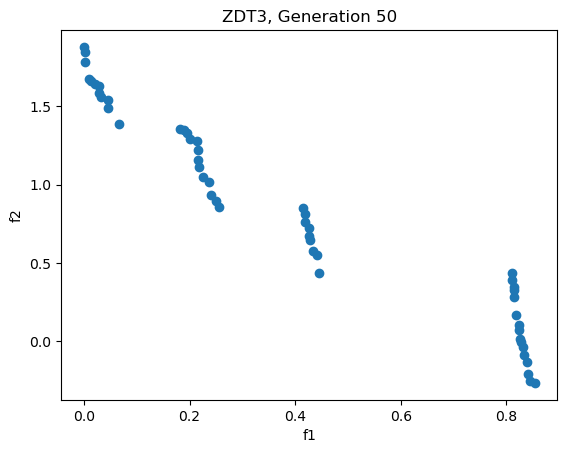

In [10]:
# Using the population records we can plot the final generation's objective functions
final_pop = generator.data[generator.data["xopt_candidate_idx"].isin(generator.history_idx[-1])]
plt.scatter(final_pop["f1"], final_pop["f2"])
plt.xlabel("f1")
plt.ylabel("f2")
plt.title(f"ZDT3, Generation {generator.n_generations}")

# File Output from Generator
In this section, we will take a look at the files which can be automatically written by the optimizer. We will create a temporary directory and clean it up at the end of this notebook.

The output files are the following.
 - `data.csv`: All data evaluated during the optimization
 - `populations.csv`: Each population is written here with a column `xopt_generation` to distinguish which generation the row belongs to
 - `checkpoints`: This generator periodically saves its full state to timestamped files in this directory

In [11]:
# Setup our output directory
output_dir = tempfile.mkdtemp()
print(f"Will write data to \"{output_dir}\"")

Will write data to "C:\Users\chris\AppData\Local\Temp\tmpho_1u8ye"


In [12]:
# Set up a generator configured to output data
generator = NSGA2Generator(
    vocs=prob_vocs,
    output_dir=output_dir,  # Where will we write data
    checkpoint_freq=8,  # How often (in terms of generations) should we save the optimizer state?
)

# Run it for a couple of generations
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()

In [13]:
# Check out the generated files
print(f"\"{output_dir}\": {os.listdir(output_dir)}")
checkpoint_dir = os.path.join(output_dir, "checkpoints")
print(f"\"checkpoints\": {os.listdir(checkpoint_dir)}")

"C:\Users\chris\AppData\Local\Temp\tmpho_1u8ye": ['checkpoints', 'data.csv', 'populations.csv']
"checkpoints": ['20250302_181156_1.txt', '20250302_181157_1.txt', '20250302_181158_1.txt', '20250302_181159_1.txt']


In [14]:
# In the event data was already written to `output_dir` the generator will choose a new path with a numeric suffix
# to avoid overwriting anything.
X = Xopt(generator=NSGA2Generator(vocs=prob_vocs, output_dir=output_dir), evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()

# Compare the requested path and where the data ended up
print(f"Requested path: \"{output_dir}\"")
print(f"Path used:      \"{X.generator.output_dir}\"")

Requested path: "C:\Users\chris\AppData\Local\Temp\tmpho_1u8ye"
Path used:      "C:\Users\chris\AppData\Local\Temp\tmpho_1u8ye_2"


In [15]:
# Load all data back in
df = pd.read_csv(os.path.join(generator.output_dir, "data.csv"))
df.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.009919,0.119884,0.953559,0.989519,0.566655,0.541573,0.474334,0.107429,0.031093,0.039052,...,0.906318,0.777098,0.301339,0,33,0.009919,5.697791,5.943640,0.000033,False
1,0.019104,0.289304,0.058954,0.158939,0.738845,0.818502,0.641377,0.958970,0.788345,0.212041,...,0.250655,0.904711,0.421850,0,16,0.019104,5.674799,6.024848,0.000010,False
2,0.042253,0.234874,0.743926,0.176754,0.051207,0.090319,0.611766,0.767635,0.997110,0.887163,...,0.860457,0.073962,0.958841,0,13,0.042253,4.840347,5.357125,0.000010,False
3,0.068387,0.306854,0.413538,0.103553,0.061787,0.819098,0.413908,0.681527,0.211400,0.115686,...,0.961188,0.156624,0.499062,0,11,0.068387,4.353041,4.994777,0.000008,False
4,0.100427,0.862513,0.598056,0.434372,0.678751,0.889657,0.327628,0.385876,0.248184,0.061461,...,0.005875,0.666771,0.972464,0,7,0.100427,4.248060,4.951912,0.000008,False


In [16]:
# Load the populations and get just the last population
df = pd.read_csv(os.path.join(generator.output_dir, "populations.csv"))
last_pop = df[df["xopt_generation"] == df["xopt_generation"].max()]
last_pop.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error,xopt_generation
1550,0.644365,0.018219,0.006261,0.000989,0.082950,0.145531,0.157857,0.304606,0.002834,0.063417,...,0.010205,0.211270,31,1552,0.644365,0.134806,1.865484,0.000008,False,32
1551,0.000006,0.056575,0.032257,0.030505,0.085713,0.256724,0.157629,0.300694,0.027150,0.059045,...,0.008898,0.230649,31,1588,0.000006,2.022738,2.026295,0.000027,False,32
1552,0.616045,0.059226,0.005854,0.031451,0.086599,0.282824,0.093836,0.304605,0.023519,0.060487,...,0.008562,0.210992,31,1578,0.616045,0.565036,1.961961,0.000008,False,32
1553,0.438911,0.030949,0.040018,0.019186,0.021042,0.294432,0.157488,0.308846,0.026919,0.077123,...,0.010182,0.209743,31,1550,0.438911,0.595553,1.928001,0.000009,False,32
1554,0.407215,0.081285,0.005617,0.011591,0.076811,0.284709,0.159762,0.252040,0.040751,0.060342,...,0.010186,0.211492,30,1521,0.407215,0.987507,1.976066,0.000008,False,32


In [23]:
# Reload the optimizer from its last checkpoint
# NOTE: the vocs object is not retained with the checkpoint and should be added as in the following code
last_checkpoint = os.path.join(checkpoint_dir, os.listdir(checkpoint_dir)[-1])
with open(last_checkpoint) as f:
    restored_generator = NSGA2Generator.from_dict({"vocs": prob_vocs, **json.load(f)})
print(f"From file: {restored_generator}")

# Demonstrate using the generator after loading (starting optimization from its last saved point)
X = Xopt(generator=restored_generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()
print(f"Further optimization: {restored_generator}")

From file: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=32, fevals=1600)
Further optimization: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=64, fevals=3200)


In [ ]:
# Clean up the output directory
shutil.rmtree(output_dir)